In [2]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as lr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
import joblib

from trainning import store_model

class Classifiers(object):

    def __init__(self,train_data,train_labels,hyperTune=True):
        self.train_data=train_data
        self.train_labels=train_labels
        self.construct_all_models(hyperTune)

    def store_model(self, model, model_name = ""):
        # NOTE: sklearn.joblib faster than pickle of Python
        # INFO: can store only ONE object in a file
        if model_name == "": 
            model_name = type(model).__name__
        joblib.dump(model,'models/' + model_name + '_model.pkl')
    
    def construct_all_models(self,hyperTune):
        if hyperTune:
            #3 models KNN SCM and LR
            self.models={'SVM':[SVC(kernel='linear',probability=True),dict(C=np.arange(0.01, 2.01, 0.2))],\
                         'LogisticRegression':[lr(),dict(C=np.arange(0.1,3,0.1))],\
                         'KNN':[KNeighborsClassifier(),dict(n_neighbors=range(1, 100))],}
            for name,candidate_hyperParam in self.models.items():
                #update each classifier after training and tuning
                self.models[name] = self.train_with_hyperParamTuning(candidate_hyperParam[0],name,candidate_hyperParam[1])
            print ('\nTraining process finished\n\n\n')

    def train_with_hyperParamTuning(self,model,name,param_grid):
        #grid search method for hyper-parameter tuning
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
        grid.fit(self.train_data, self.train_labels)
        joblib.dump(grid,'saved_objects/' + name  + '_gridsearch.pkl')
        self.store_model(grid, name)
        
        print(
            '\nThe best hyper-parameter for -- {} is {}, the corresponding mean accuracy through 10 Fold test is {} \n'\
            .format(name, grid.best_params_, grid.best_score_))

        model = grid.best_estimator_
        train_pred = model.predict(self.train_data)
        print('{} train accuracy = {}\n'.format(name,(train_pred == self.train_labels).mean()))
        return model

    def prediction_metrics(self,test_data,test_labels,name):

        #accuracy
        print('{} test accuracy = {}\n'.format(name,(self.models[name].predict(test_data) == test_labels).mean()))

        #AUC of ROC
        prob = self.models[name].predict_proba(test_data)
        auc=roc_auc_score(test_labels,prob[:,1])
        print('Classifier {} area under curve of ROC is {}\n'.format(name,auc))

        #ROC
        fpr, tpr, thresholds = roc_curve(test_labels, prob[:,1], pos_label=1)
        self.roc_plot(fpr,tpr,name,auc)

    def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()



In [3]:
import pandas as pd
raw_data = pd.read_csv('trainning_data.csv')

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42) # set random_state to get the same training set all the time, 

train_set_labels = train_set["label"].copy()
train_set = train_set.drop(columns = "label") 
test_set_labels = test_set["label"].copy()
test_set = test_set.drop(columns = "label") 

In [5]:
classifiers = Classifiers(train_set,train_set_labels)


The best hyper-parameter for -- SVM is {'C': 0.01}, the corresponding mean accuracy through 10 Fold test is 0.9 

SVM train accuracy = 1.0



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



The best hyper-parameter for -- LogisticRegression is {'C': 0.30000000000000004}, the corresponding mean accuracy through 10 Fold test is 0.9 

LogisticRegression train accuracy = 1.0


The best hyper-parameter for -- KNN is {'n_neighbors': 1}, the corresponding mean accuracy through 10 Fold test is 0.9 

KNN train accuracy = 1.0


Training process finished





c:\Python310\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.9        0.9        0.9        0.9        0.81666667 0.81666667
 0.84166667 0.84166667 0.81666667 0.84166667 0.84166667 0.84166667
 0.84166667 0.84166667 0.84166667 0.84166667 0.84166667 0.84166667
 0.84166667 0.86666667 0.84166667 0.81666667 0.84166667 0.79166667
 0.79166667 0.79166667 0.81666667 0.76666667 0.79166667 0.54166667
 0.54166667 0.56666667 0.56666667 0.56666667 0.56666667        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        na

KNN test accuracy = 0.8

Classifier KNN area under curve of ROC is 0.8571428571428572



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


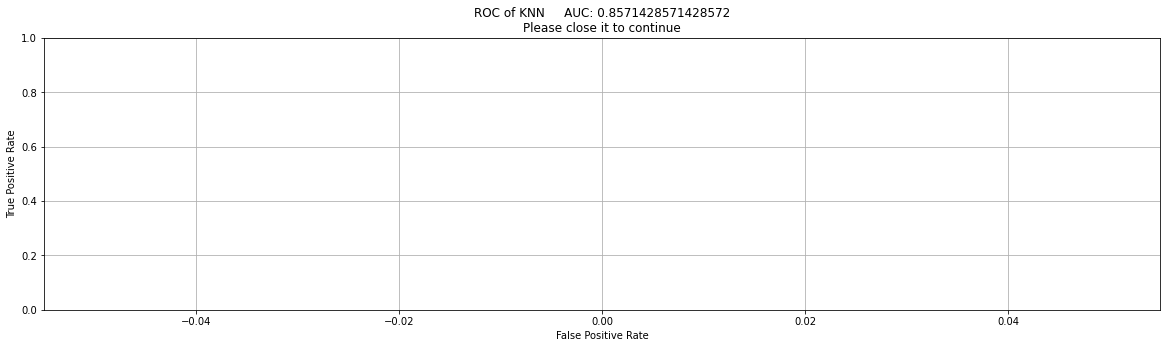

In [63]:
classifiers.prediction_metrics(test_set, test_set_labels, 'KNN')

In [58]:
for name,model in classifiers.models.items():
  print(name, model)

SVM SVC(C=0.01, kernel='linear', probability=True)
LogisticRegression LogisticRegression(C=0.30000000000000004)
KNN KNeighborsClassifier(n_neighbors=1)


In [59]:
name = 'SVM'
print('{} test accuracy = {}\n'.format(name,(classifiers.models[name].predict(test_set) == test_set_labels).mean()))
prob = classifiers.models[name].predict_proba(test_set)


SVM test accuracy = 0.9



In [60]:
auc = roc_auc_score(test_set_labels, prob[:,1])
print('Classifier {} area under curve of ROC is {}\n'.format(name,auc))

fpr, tpr, thresholds = roc_curve(test_set_labels, prob[:,1], pos_label=1)

Classifier SVM area under curve of ROC is 0.8571428571428571



c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [61]:
def roc_plot(self,fpr,tpr,name,auc):
        plt.figure(figsize=(20,5))
        plt.plot(fpr,tpr)
        plt.ylim([0.0,1.0])
        plt.ylim([0.0, 1.0])
        plt.title('ROC of {}     AUC: {}\nPlease close it to continue'.format(name,auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.grid(True)
        plt.show()

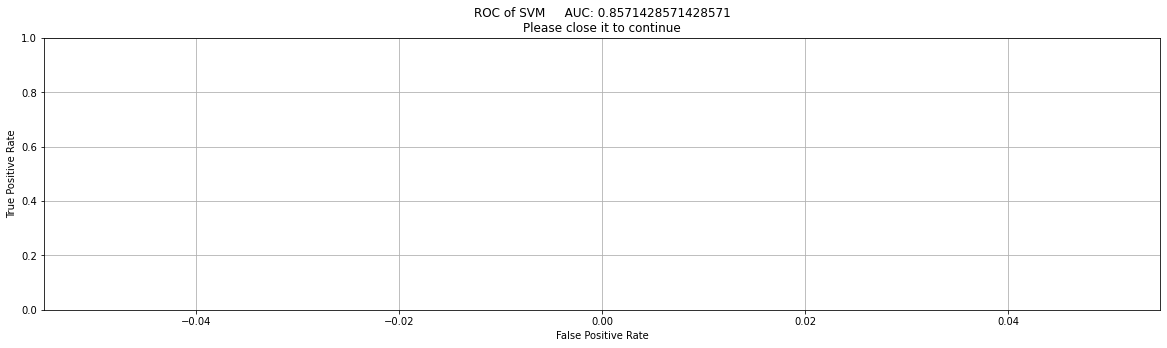

In [62]:
classifiers.roc_plot(fpr, tpr, name, auc)

c:\Python310\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
